In [2]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


In [3]:
# --- Load Dataset ---
# Import the dataset uploaded to the repo
url = "https://raw.githubusercontent.com/MaharLeika18/Data-Mining---Python/refs/heads/main/Finals_Act/Groceries_dataset.csv"
data = pd.read_csv(url)

# Inspect first few rows
print(data.head())

   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk


In [4]:
# --- Data Preprocessing ---
# One-hot encode all items 
transactions = data.groupby('Member_number')[
    'itemDescription'].apply(list).values.tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Inspect
df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [5]:
# --- Use apriori ---
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

print(frequent_itemsets.head())

    support                 itemsets
0  0.015393  (Instant food products)
1  0.078502               (UHT-milk)
2  0.031042          (baking powder)
3  0.119548                   (beef)
4  0.079785                (berries)


In [6]:
# Generate rules where confidence > 0.6
rulesConfi = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rulesConfi = rulesConfi.round(4)

# Lift > 1.2
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rulesLift = rulesLift.round(4)

In [7]:
# Expand multi-item rules into one row per (antecedent, consequent) pair for heatmap
expandedConfi = []
expandedLift = []

for _, row in rulesConfi.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            expandedConfi.append({
                'antecedent': a,
                'consequent': c,
                'confidence': row['confidence'],
                'support': row['support']
            })

for _, row in rulesLift.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            expandedLift.append({
                'antecedent': a,
                'consequent': c,
                'confidence': row['confidence'],
                'support': row['support']
            })

expandedConfi_df = pd.DataFrame(expandedConfi)
expandedLift_df = pd.DataFrame(expandedLift)

In [8]:
# --- Display top 5 rules w/ metrics --- 
# Sort and get top 5 by confidence
top5_rules = rulesConfi.sort_values(by="confidence", ascending=False).head(5).copy()

# Convert frozensets to readable strings
top5_rules["antecedents"] = top5_rules["antecedents"].apply(lambda x: ", ".join(list(x)))
top5_rules["consequents"] = top5_rules["consequents"].apply(lambda x: ", ".join(list(x)))

# Select columns to show
cols = ["antecedents", "consequents", "support", "confidence", "lift"]

# Plot table
fig = go.Figure(
    data=[go.Table(
        columnwidth=[90, 70, 60, 60, 60],
        header=dict(
            values=[f"<b>{col}</b>" for col in cols],
            fill_color="lightgrey",
            align="left",
            font=dict(size=12, color="black"),
        ),
        cells=dict(
            values=[top5_rules[col] for col in cols],
            fill_color="white",
            align="left",
            font=dict(size=11),
            height=28
        )
    )]
)

fig.update_layout(
    title="Top 5 Association Rules (Confidence > 0.6)",
    height=450,
    width=650
)

fig.show()

In [9]:
# Sort and get top 5 by lift
top5_rules = rulesLift.sort_values(by="lift", ascending=False).head(5).copy()

# Convert frozensets to readable strings
top5_rules["antecedents"] = top5_rules["antecedents"].apply(lambda x: ", ".join(list(x)))
top5_rules["consequents"] = top5_rules["consequents"].apply(lambda x: ", ".join(list(x)))

# Select columns to show
cols = ["antecedents", "consequents", "support", "confidence", "lift"]

# Plot table
fig = go.Figure(
    data=[go.Table(
        columnwidth=[80, 80, 60, 60, 60],
        header=dict(
            values=[f"<b>{col}</b>" for col in cols],
            fill_color="lightgrey",
            align="left",
            font=dict(size=12, color="black"),
        ),
        cells=dict(
            values=[top5_rules[col] for col in cols],
            fill_color="white",
            align="left",
            font=dict(size=11),
            height=28
        )
    )]
)

fig.update_layout(
    title="Top 5 Association Rules (Lift > 1.2)",
    height=460,
    width=700
)

fig.show()

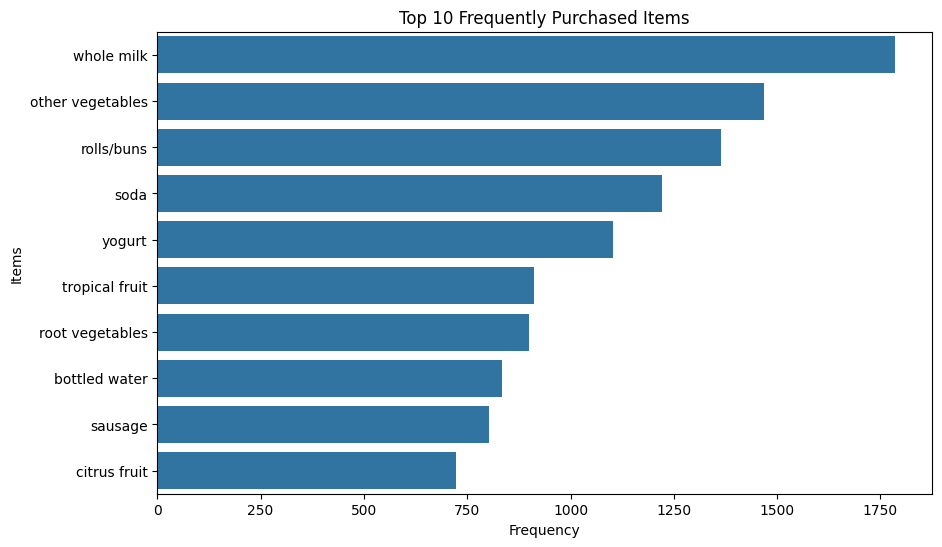

In [16]:
# Bar Chart for top purchased items
item_frequencies = df.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=item_frequencies.head(10).values,
            y=item_frequencies.head(10).index)
plt.title('Top 10 Frequently Purchased Items')
plt.xlabel('Frequency')
plt.ylabel('Items')
plt.show()

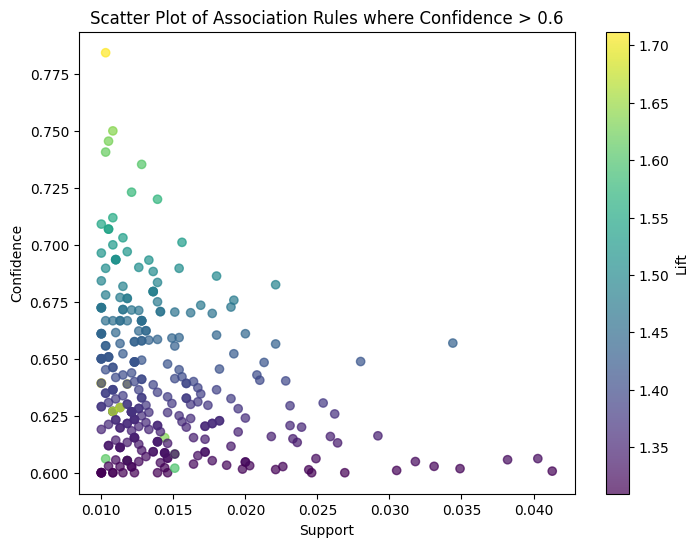

In [ ]:
# Scatter Plot of Rules(Support vs Confidence) where Confidence > 0.6
plt.figure(figsize=(8, 6))
scatter = plt.scatter(rulesConfi['support'], rulesConfi['confidence'],
                      c=rulesConfi['lift'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Scatter Plot of Association Rules where Confidence > 0.6')
plt.show()

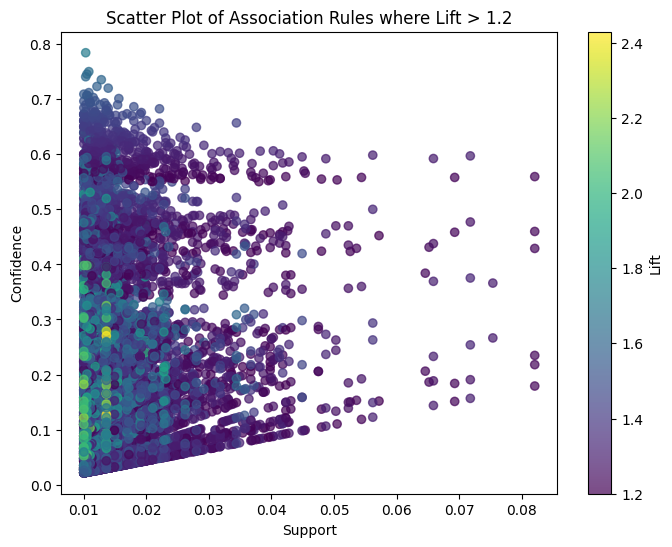

In [12]:
# Scatter Plot of Rules(Support vs Confidence) where Lift > 1.2
plt.figure(figsize=(8, 6))
scatter = plt.scatter(rulesLift['support'], rulesLift['confidence'],
                      c=rulesLift['lift'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Scatter Plot of Association Rules where Lift > 1.2')
plt.show()

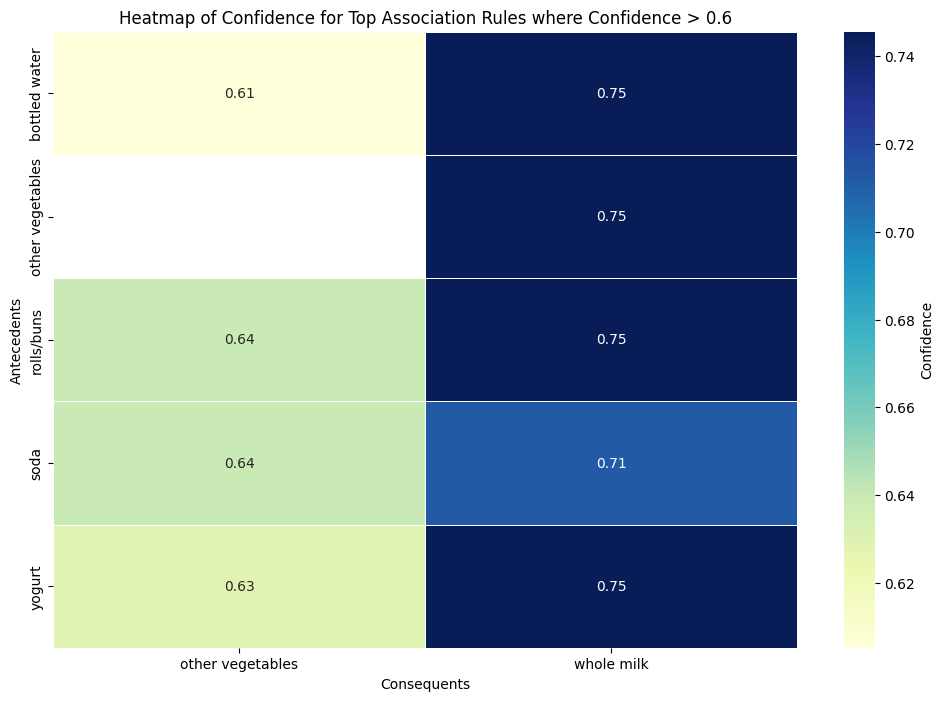

In [13]:
# Heatmap of Confidence where Confidence > 0.6
top_ants = expandedConfi_df.groupby('antecedent')['support'].sum().nlargest(5).index
top_cons = expandedConfi_df.groupby('consequent')['support'].sum().nlargest(5).index

filtered = expandedConfi_df[
    (expandedConfi_df['antecedent'].isin(top_ants)) &
    (expandedConfi_df['consequent'].isin(top_cons))
]

filtered_unique = (
    filtered.groupby(['antecedent', 'consequent'], as_index=False)
    .agg({'confidence': 'max'})
)

heatmap_data = filtered_unique.pivot(
    index='antecedent', columns='consequent', values='confidence')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu',
            linewidths=0.5, cbar_kws={'label': 'Confidence'})
plt.title('Heatmap of Confidence for Top Association Rules where Confidence > 0.6')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

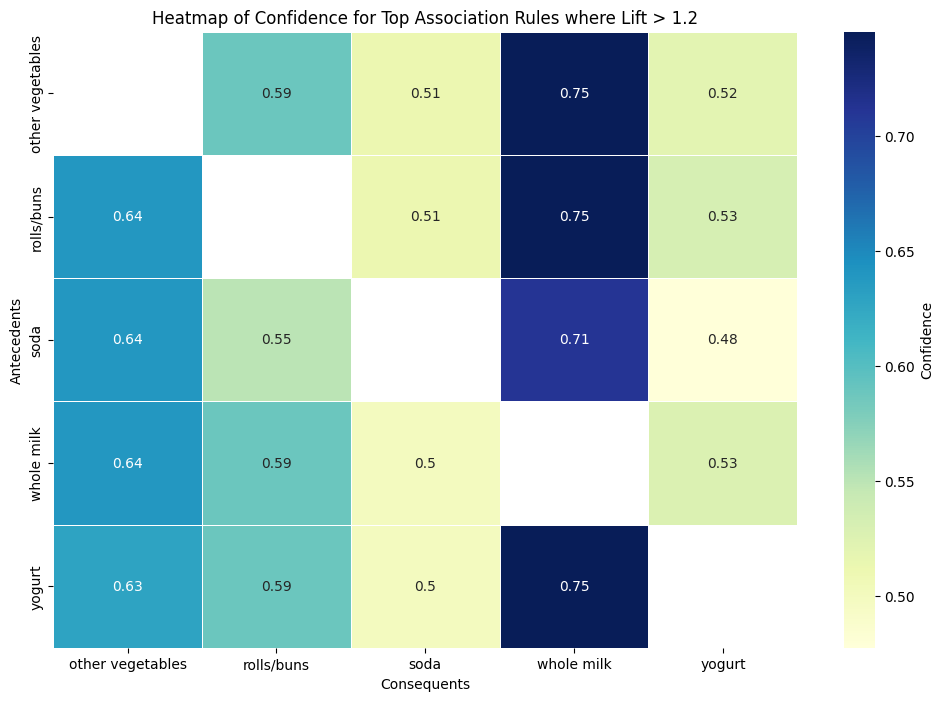

In [14]:
# Heatmap of Confidence where Lift > 1.2
top_ants = expandedLift_df.groupby('antecedent')['support'].sum().nlargest(5).index
top_cons = expandedLift_df.groupby('consequent')['support'].sum().nlargest(5).index

filtered = expandedLift_df[
    (expandedLift_df['antecedent'].isin(top_ants)) &
    (expandedLift_df['consequent'].isin(top_cons))
]

filtered_unique = (
    filtered.groupby(['antecedent', 'consequent'], as_index=False)
    .agg({'confidence': 'max'})
)

heatmap_data = filtered_unique.pivot(
    index='antecedent', columns='consequent', values='confidence')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu',
            linewidths=0.5, cbar_kws={'label': 'Confidence'})
plt.title('Heatmap of Confidence for Top Association Rules where Lift > 1.2')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()